In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My\ Drive

/content/drive/My Drive


In [0]:
!pip install bindsnet

     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 204kB 38.7MB/s 
  Created wheel for bindsnet: filename=bindsnet-0.2.7-cp36-none-any.whl size=81417 sha256=4fb91d44eb5c3a274277186048709d10022ebbc9cadf7be3b1b947089c74f300
  Stored in directory: /root/.cache/pip/wheels/d3/68/80/eca244a3d072961b5152d5906475ffc9d9b2453c9e060535e3
Successfully built bindsnet


In [0]:
!pip install pytorchtools

In [0]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import argparse
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input

# Build a simple two-layer, input-output network.
from bindsnet.network.monitors import Monitor
from bindsnet.network.nodes import LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.utils import get_square_weights

import easydict

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
args = easydict.EasyDict({
        "seed": 0,
        "n_neurons": 500,
        "n_epochs": 75,
        "n_examples": 1000,
        "n_workers": -1,
        "time": 251,
        "dt": 1.0,
        "intensity": 64,
        "progress_interval": 10,
        "update_interval": 250,
        "gpu": True,
        "device_id": 0,
        "train": True
})

In [0]:
seed = args.seed
n_neurons = args.n_neurons
n_epochs = args.n_epochs
n_examples = args.n_examples
n_workers = args.n_workers
time = args.time
dt = args.dt
intensity = args.intensity
progress_interval = args.progress_interval
update_interval = args.update_interval
train = args.train
gpu = args.gpu
device_id = args.device_id
n_iters = n_examples

np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

# Sets up Gpu use
if gpu and torch.cuda.is_available():
    torch.cuda.set_device(device_id)
    # torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.manual_seed(seed)

In [0]:
# dt: the simulation time step
network = Network(dt=dt)

# 入力層
inpt = Input(2, shape=(1,2))
network.add_layer(inpt, name="I")

# リザーバー層
output = LIFNodes(n_neurons, thresh=-52 + np.random.randn(n_neurons).astype(float))
network.add_layer(output, name="O")

# 入力層->リザーバー層とリザーバー層->リザーバー層のコネクションを作成
C1 = Connection(source=inpt, target=output, w=torch.randn(inpt.n, output.n))
C2 = Connection(source=output, target=output, w=torch.randn(output.n, output.n))
network.add_connection(C1, source="I", target="O")
network.add_connection(C2, source="O", target="O")

# スパイクのモニター(入力、リザーバー)
spikes = {}
for l in network.layers:
    spikes[l] = Monitor(network.layers[l], ["s"], time=time)
    network.add_monitor(spikes[l], name="%s_spikes" % l)

# ボルトのモニター(リザーバー)
voltages = {"O": Monitor(network.layers["O"], ["v"], time=time)}
network.add_monitor(voltages["O"], name="O_voltages")

# Directs network to GPU
if gpu:
    network.to("cuda")

# dataset作成
class MyDataset(torch.utils.data.Dataset):
    # xy.shape = (n, time, xy)
    # F.shape = (n, time, F)
    def __init__(self, xy, F, transform=None):
        self.transform = transform
        self.data_num = xy.shape[0]
        self.data = xy
        self.label = F

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label =  self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [0]:
train_data = pd.read_csv("train_data.csv", header = None)
train_data = np.array(train_data)
train_data = train_data.reshape((1000,251,4))
# from IPython.core.debugger import Pdb; Pdb().set_trace()
xy = train_data[:900,:,0:2]
F = train_data[:900,:,2:4]
dataset = MyDataset(xy, F, transform=None)

# Create a dataloader to iterate and batch data
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=gpu
)

# Run training data on reservoir computer and store (spikes per neuron, label) per example.
train_pairs = []
pbar = tqdm(enumerate(dataloader))

# 
# このループではトレーニングデータを作成していると考えて良い
# q = int((bs-1)/2)
for (i, dataPoint) in pbar:
    # data, labelを取り出している
    datum = dataPoint[0].view(time, 2).to(device_id)
    label = dataPoint[1].view(time, 2)
    pbar.set_description_str("Train progress: (%d / %d)" % (i, n_iters))
    for j in range(50):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
    for j in range(251):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
      train_pairs.append([spikes["O"].get("s").sum(0), label[j]])
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
    network.reset_state_variables()
np.save("train_pairs", train_pairs)

valid_pairs作成

In [0]:
"""
valid_data = pd.read_csv("valid_data.csv", header = None)
valid_data = np.array(train_data)
valid_data = train_data.reshape((1000,251,4))
"""
xy = train_data[900:990,:,0:2]
F = train_data[900:990,:,2:4]
valid_dataset = MyDataset(xy, F, transform=None)

# Create a dataloader to iterate and batch data
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=gpu
)

# Run training data on reservoir computer and store (spikes per neuron, label) per example.
valid_pairs = []
pbar = tqdm(enumerate(valid_dataloader))

for (i, dataPoint) in pbar:
    datum = dataPoint[0].view(time, 2).to(device_id)
    label = dataPoint[1].view(time, 2)
    pbar.set_description_str("Train progress: (%d / %d)" % (i, n_iters))
    for j in range(50):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
    for j in range(251):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
      valid_pairs.append([spikes["O"].get("s").sum(0), label[j]])
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
    network.reset_state_variables()
np.save("valid_pairs", valid_pairs)

test_pairs作成

In [0]:
"""
test_data = pd.read_csv("test_data.csv", header = None)
test_data = np.array(test_data)
test_data = test_data.reshape((1000,251,4))
"""

xy = train_data[990:, :, 0:2]
F = train_data[990:, :, 2:4]
test_dataset = MyDataset(xy, F, transform=None)


# Create a dataloader to iterate and batch data
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=gpu
)

test_pairs = []
pbar = tqdm(enumerate(test_dataloader))

for (i, dataPoint) in pbar:
    datum = dataPoint[0].view(time, 2).to(device_id)
    label = dataPoint[1].view(time, 2)
    pbar.set_description_str("Train progress: (%d / %d)" % (i, n_iters))
    for j in range(50):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
    for j in range(251):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
      test_pairs.append([spikes["O"].get("s").sum(0), label[j]])
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
    network.reset_state_variables()
np.save("test_pairs", test_pairs)

In [0]:
train_pairs = np.load("train_pairs.npy", allow_pickle=True)
valid_pairs = np.load("valid_pairs.npy", allow_pickle=True)

# 回帰モデル
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.linear_1 = nn.Linear(input_size, 500)
        self.linear_2 = nn.Linear(500, 2)
        # self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        # self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        # out = self.dropout1(x.float().view(-1))
        out = torch.relu(self.linear_1(x.float().view(-1)))
        out = self.dropout2(out)
        out = self.linear_2(out)
        return out

# Create and train logistic regression model on reservoir outputs.
model = NN(n_neurons).to(device_id)
criterion = torch.nn.MSELoss(reduction="sum")
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.9))

# Training the Model
# 回帰モデルを先ほど生成したデータでトレーニング
print("\n Training the read out")
# model.load_state_dict(torch.load("model"))
model.load_state_dict(torch.load('checkpoint.pt'))
patience = 30
early_stopping = EarlyStopping(patience=patience, verbose=True)
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = [] 
pbar = tqdm(enumerate(range(n_epochs)))
for epoch, _ in pbar:
    model.train()
    for i, (s, l) in enumerate(train_pairs):
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(s.view(-1))
        label = l.float().to(device_id)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()
    for i, (s, l) in enumerate(valid_pairs):
        # Forward + Backward + Optimize
        outputs = model(s.view(-1))
        label = l.float().to(device_id)
        loss = criterion(outputs, label)
        valid_losses.append(loss.item())

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    """
    pbar.set_description_str(
        "Epoch: %d/%d, train_loss: %.4f, valid_loss: %.4f"
        % (epoch + 1, n_epochs, train_loss, valid_loss)
    )
    """
    print("Epoch: %d/%d, train_loss: %.4f, valid_loss: %.4f"
        % (epoch + 1, n_epochs, train_loss, valid_loss))
    train_losses = []
    valid_losses = []
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
model.load_state_dict(torch.load('checkpoint.pt'))
torch.save(model.state_dict(), "model")


 Training the read out


Epoch: 1/75, train_loss: 0.4449, valid_loss: 0.5377
Validation loss decreased (inf --> 0.537665).  Saving model ...
Epoch: 2/75, train_loss: 0.4427, valid_loss: 0.5291
Validation loss decreased (0.537665 --> 0.529057).  Saving model ...
Epoch: 3/75, train_loss: 0.4410, valid_loss: 0.5233
Validation loss decreased (0.529057 --> 0.523279).  Saving model ...
Epoch: 4/75, train_loss: 0.4410, valid_loss: 0.5332
EarlyStopping counter: 1 out of 30
Epoch: 5/75, train_loss: 0.4381, valid_loss: 0.5326
EarlyStopping counter: 2 out of 30
Epoch: 6/75, train_loss: 0.4367, valid_loss: 0.5240
EarlyStopping counter: 3 out of 30
Epoch: 7/75, train_loss: 0.4421, valid_loss: 0.5229
Validation loss decreased (0.523279 --> 0.522944).  Saving model ...
Epoch: 8/75, train_loss: 0.4380, valid_loss: 0.5215
Validation loss decreased (0.522944 --> 0.521455).  Saving model ...
Epoch: 9/75, train_loss: 0.4388, valid_loss: 0.5218
EarlyStopping counter: 1 out of 30
Epoch: 10/75, train_loss: 0.4361, valid_loss: 0.5214

In [0]:
# 回帰モデル
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.linear_1 = nn.Linear(input_size, 500)
        self.linear_2 = nn.Linear(500, 2)
        # self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        # self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        # out = self.dropout1(x.float().view(-1))
        out = torch.relu(self.linear_1(x.float().view(-1)))
        out = self.dropout2(out)
        out = self.linear_2(out)
        return out

# Create and train logistic regression model on reservoir outputs.
model = NN(n_neurons).to(device_id)
criterion = torch.nn.MSELoss(reduction="sum")
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.9))

# model.load_state_dict(torch.load("model"))
model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()
loss, total = 0, 0
k = 0
test_pairs = np.load("test_pairs.npy", allow_pickle=True)
outs = np.zeros([251*10,2])
labels = np.zeros([251*10,2])
for s, label in test_pairs:
    k += 1
    outputs = model(s)
    outs[k-1,:] = np.array(outputs.cpu().detach().numpy())
    labels[k-1,:] = np.array(label.cpu().detach().numpy())
    loss += criterion(outputs, label.float().to(device_id)).data
    total += 1

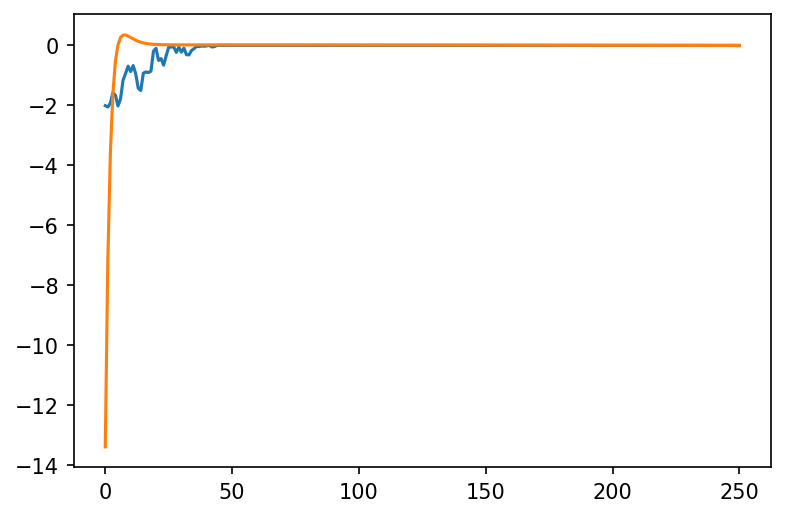

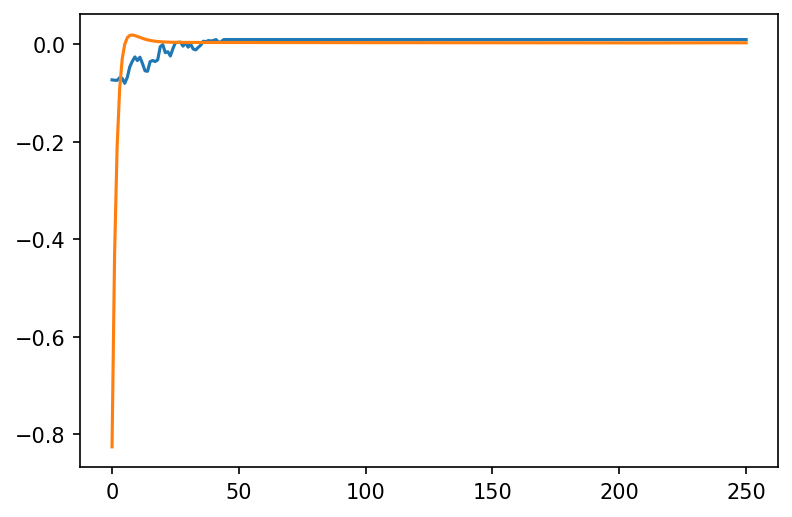

In [11]:
l = 0
a = 251*l
b = a + 251
plt.figure(dpi=150)
plt.plot(outs[a:b,0])
plt.plot(labels[a:b,0])
plt.show()

plt.figure(dpi=150)
plt.plot(outs[a:b,1])
plt.plot(labels[a:b,1])
plt.show()


prediction = np.zeros((251,2))
ans = np.zeros((251,2))
prediction[:,0] = outs[a:b,0]
prediction[:,1] = outs[a:b,1]
ans[:,0] = labels[a:b,0]
ans[:,1] = labels[a:b,1]
np.savetxt("prediction.csv", prediction)
np.savetxt("ans.csv", ans)